In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.relative_locator import locate_with
import requests
import time
import pandas as pd

Construct a list of all the URL's that we comprise of matches of Carlos

In [2]:
url = 'https://www.tennisabstract.com/charting/meta.html#CarlosAlcaraz'

page = requests.get(url)
soup = BeautifulSoup(page.text, 'html')

table = soup.find_all('table')[1].find_all('tr')[1]
a_links = table.find_all('a')

matches = [link.get('href') for link in a_links]
matches = matches[3:]

base_url = 'https://www.tennisabstract.com/charting/'
matches = [base_url + url for url in matches]

In [11]:
#url = 'https://www.tennisabstract.com/charting/20200829-M-Trieste_CH-SF-Lorenzo_Musetti-Carlos_Alcaraz.html'

Making an assumption here that the last name in the URL appears 2nd in the table rows when selecting Server breakdowns etc.

In [12]:
columns = ["Serve Type", "Total Points", "Won (%)", "Aces (%)", "Unret (%)", "Forced Errors (%)",
           "<=3W (%)", "1stIn (%)", "Double Fault (%)"]
serve_df = pd.DataFrame(columns=columns)

In [93]:
for url in matches:

    # Set up Selenium WebDriver
    driver = webdriver.Chrome()  # Make sure you have chromedriver installed and added to PATH
    driver.get(url)
    
    # If Alcaraz is last name in URL, then relevant id is serve2 otherwise its serve1
    last_name_in_url = url[-12:-5]
    if last_name_in_url == 'Alcaraz':
        serve_id = 'serve2'
    else:
        serve_id = 'serve1'

    time.sleep(2)

    # Click on the "Serve Breakdown" span with id="serve2"
    serve_breakdown_button = driver.find_element("id", serve_id)
    serve_breakdown_button.click()

    time.sleep(2)
    
    
    table = driver.find_element("id", "reportable")
    rows = table.find_elements("tag name", "tr")
    df_list = []
    for row in rows:
        cells = row.find_elements("tag name", "td")
        data = [cell.text for cell in cells]
        df_list.append(data)
    
    match_df = pd.DataFrame(df_list[1:], columns=columns)
    
    df = pd.DataFrame(df_list[1:], columns=columns)
    serve_df = pd.concat([serve_df, match_df], ignore_index=True)
    
    # Get the page source after the table is loaded
    #html_content = driver.page_source
    driver.quit()

    # Parse the page with BeautifulSoup
    #soup = BeautifulSoup(page.text, 'html')

In [15]:
#serve_df.to_csv('serve.csv', index=False)
serve_df = pd.read_csv("serve.csv")

### Now let's extract data from the 2024 Wimbledon final

In [59]:
wimbledon_final_df = serve_df.iloc[1688:1699]
wimbledon_final_df.set_index('Serve Type', inplace=True)
wimbledon_final_df

,Total Points,Won (%),Aces (%),Unret (%),Forced Errors (%),<=3W (%),1stIn (%),Double Fault (%)
Serve Type,,,,,,,,
Deuce Court,49,37 (76%),2 (4%),0 (0%),8 (16%),20 (41%),29 (59%),3 (6%)
Ad Court,46,30 (65%),3 (7%),2 (4%),12 (26%),21 (46%),27 (59%),3 (7%)
Wide serves,39,24 (62%),2 (5%),1 (3%),8 (21%),17 (44%),24 (62%),2 (5%)
Body serves,31,21 (68%),0 (0%),0 (0%),3 (10%),9 (29%),16 (52%),2 (6%)
T serves,25,22 (88%),3 (12%),1 (4%),9 (36%),15 (60%),16 (64%),2 (8%)
Deuce-Wide,18,13 (72%),2 (11%),0 (0%),3 (17%),9 (50%),13 (72%),1 (6%)
Ad-Wide,21,11 (52%),0 (0%),1 (5%),5 (24%),8 (38%),11 (52%),1 (5%)
Deuce-Body,23,17 (74%),0 (0%),0 (0%),3 (13%),8 (35%),14 (61%),1 (4%)
Ad-Body,8,4 (50%),0 (0%),0 (0%),0 (0%),1 (13%),2 (25%),1 (13%)


In [58]:
wimbledon_final_df['Total Points'][0:10].sum()

268

In [220]:
# Get data on total points played (across both serves) for given positions
deuce_data = wimbledon_final_df.loc[['Deuce-Wide', 'Deuce-Body', 'Deuce-T']]['Total Points'] / 49*100
ad_data = wimbledon_final_df.loc[['Ad-Wide', 'Ad-Body', 'Ad-T']]['Total Points'] / 46*100
#serve_data = pd.concat([deuce_data, ad_data])

In [221]:
deuce_percentages = {deuce_data.index[row]: data for row, data in enumerate(deuce_data)}
deuce_percentages = {k: int(v) for k, v in deuce_percentages.items()}

ad_percentages = {ad_data.index[row]: data for row, data in enumerate(ad_data)}
ad_percentages = {k: int(v) for k, v in ad_percentages.items()}

serve_percentages = {serve_data.index[row]: data for row, data in enumerate(serve_data)}
serve_percentages = {k: int(v) for k, v in serve_percentages.items()}
#serve_percentages

In [185]:
# Get data on 1st serve percentages 
first_serve_deuce_data = wimbledon_final_df.loc[['Deuce-Wide', 'Deuce-Body', 'Deuce-T']]['1stIn (%)']
first_serve_ad_data = wimbledon_final_df.loc[['Ad-Wide', 'Ad-Body', 'Ad-T']]['1stIn (%)']

# Convert to dicts
first_serve_deuce_percentages = {first_serve_deuce_data.index[row]: data for row, data in enumerate(first_serve_deuce_data)}
first_serve_ad_percentages    = {first_serve_ad_data.index[row]: data for row, data in enumerate(first_serve_ad_data)}
first_serve_deuce_percentages = {k: int(v[-4:-2]) for k, v in first_serve_deuce_percentages.items()}
first_serve_ad_percentages    = {k: int(v[-4:-2]) for k, v in first_serve_ad_percentages.items()}

In [207]:
deuce_win_data = wimbledon_final_df.loc[['Deuce-Wide', 'Deuce-Body', 'Deuce-T']]['Won (%)']
ad_win_data = wimbledon_final_df.loc[['Ad-Wide', 'Ad-Body', 'Ad-T']]['Won (%)']

deuce_win_pctg = {deuce_win_data.index[row]: data for row, data in enumerate(deuce_win_data)}
ad_win_pctg    = {ad_win_data.index[row]: data for row, data in enumerate(ad_win_data)}
deuce_win_pctg = {k: int(v[-4:-2]) for k, v in deuce_win_pctg.items()}
ad_win_pctg    = {k: int(v[-4:-2]) for k, v in ad_win_pctg.items()}

In [208]:
serve_positions_relative = {
    'Deuce-Wide': (0.3, 0.78),
    'Deuce-Body': (0.3, 0.65),
    'Deuce-T': (0.3, 0.53),
    'Deuce-Text': (0.15, 0.65),
    'Ad-Wide': (0.3, 0.22),
    'Ad-Body': (0.3, 0.35),
    'Ad-T': (0.3, 0.48),
    'Ad-Text': (0.15, 0.35),
    'Title' : (0.3, 0.15)
}

In [216]:
win_percentage_relative = {
    'Deuce-Wide': (0.4, 0.78),
    'Deuce-Body': (0.4, 0.65),
    'Deuce-T': (0.4, 0.53),
    'Ad-Wide': (0.4, 0.22),
    'Ad-Body': (0.4, 0.35),
    'Ad-T': (0.4, 0.48),
    'Title': (0.4, 0.10)
}

In [217]:
first_serve_percentage_relative = {
    'Deuce-Wide': (0.48, 0.78),
    'Deuce-Body': (0.48, 0.65),
    'Deuce-T': (0.48, 0.53),
    'Ad-Wide': (0.48, 0.22),
    'Ad-Body': (0.48, 0.35),
    'Ad-T': (0.48, 0.48),
    'Title': (0.48, 0.15)
}

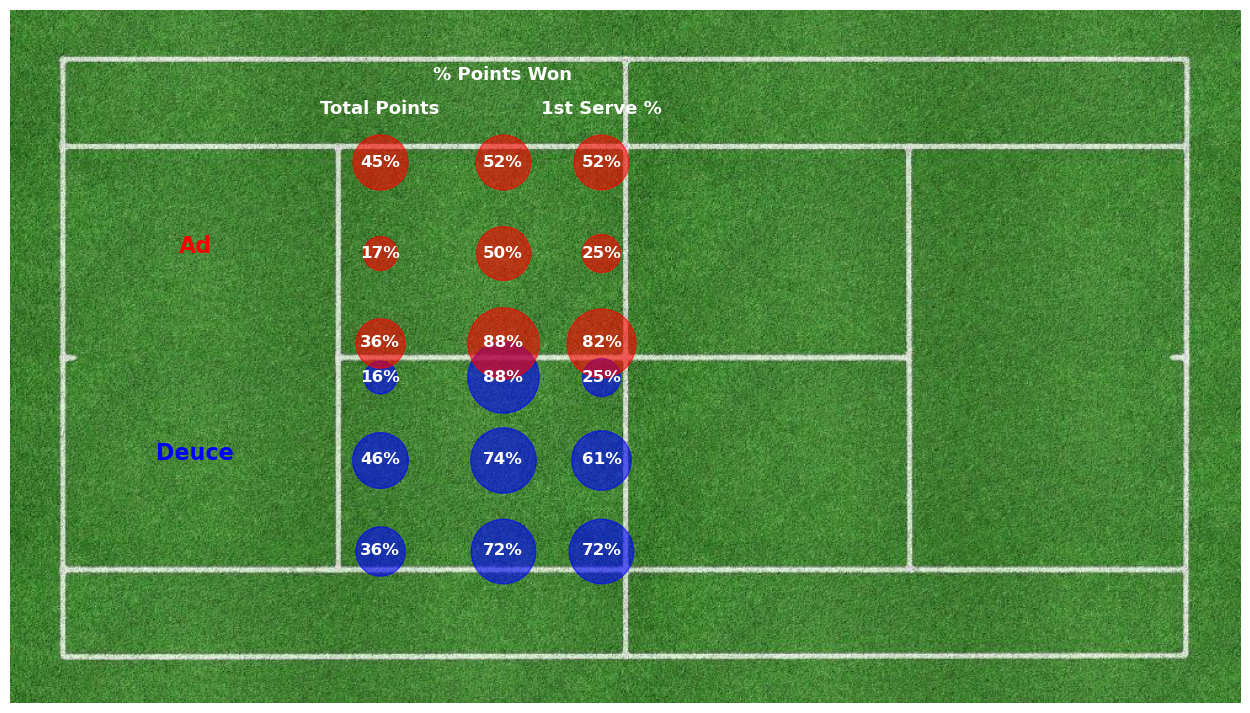

In [222]:
import matplotlib.pyplot as plt
from PIL import Image

court_image = Image.open("tennis_court.jpg")
fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(court_image)

img_width, img_height = court_image.size
serve_positions = {k: (int(v[0] * img_width), int(v[1] * img_height)) for k, v in serve_positions_relative.items()}
first_serve_percentage = {k: (int(v[0] * img_width), int(v[1] * img_height)) for k, v in first_serve_percentage_relative.items()}
win_percentage = {k: (int(v[0] * img_width), int(v[1] * img_height)) for k, v in win_percentage_relative.items()}


# Total points Deuce court
scale_factor=35
for location, percent in deuce_percentages.items():
    x, y = serve_positions[location]
    bubble_size = scale_factor * percent
    ax.scatter(x, y, s=bubble_size, color="blue", alpha=0.6)
    ax.text(x, y, f"{percent}%", color="white", ha="center", va="center", fontsize=12, weight="bold")

# Total points Ad court
scale_factor=35
for location, percent in ad_percentages.items():
    x, y = serve_positions[location]
    bubble_size = scale_factor * percent
    ax.scatter(x, y, s=bubble_size, color="red", alpha=0.6)
    ax.text(x, y, f"{percent}%", color="white", ha="center", va="center", fontsize=12, weight="bold")
    

# Win % Deuce court
scale_factor=30
for location, percent in deuce_win_pctg.items():
    x, y = win_percentage[location]
    bubble_size = scale_factor * percent
    ax.scatter(x, y, s=bubble_size, color="blue", alpha=0.6)
    ax.text(x, y, f"{percent}%", color="white", ha="center", va="center", fontsize=12, weight="bold")

# Win % Ad court
scale_factor=30
for location, percent in ad_win_pctg.items():
    x, y = win_percentage[location]
    bubble_size = scale_factor * percent
    ax.scatter(x, y, s=bubble_size, color="red", alpha=0.6)
    ax.text(x, y, f"{percent}%", color="white", ha="center", va="center", fontsize=12, weight="bold")  
    
    
    
# 1st serve % Deuce court
scale_factor=30
for location, percent in first_serve_deuce_percentages.items():
    x, y = first_serve_percentage[location]
    bubble_size = scale_factor * percent
    ax.scatter(x, y, s=bubble_size, color="blue", alpha=0.6)
    ax.text(x, y, f"{percent}%", color="white", ha="center", va="center", fontsize=12, weight="bold")

# 1st server % Ad court
scale_factor=30
for location, percent in first_serve_ad_percentages.items():
    x, y = first_serve_percentage[location]
    bubble_size = scale_factor * percent
    ax.scatter(x, y, s=bubble_size, color="red", alpha=0.6)
    ax.text(x, y, f"{percent}%", color="white", ha="center", va="center", fontsize=12, weight="bold")
    
    

ax.text(serve_positions['Title'][0], serve_positions['Title'][1], "Total Points", color="white", fontsize=13, weight="bold", ha="center")
ax.text(win_percentage['Title'][0], win_percentage['Title'][1], "% Points Won", color="white", fontsize=13, weight="bold", ha="center")
ax.text(first_serve_percentage['Title'][0], first_serve_percentage['Title'][1], "1st Serve %", color="white", fontsize=13, weight="bold", ha="center")

# Deuce and Ad text
ax.text(serve_positions['Deuce-Text'][0], serve_positions['Deuce-Text'][1], "Deuce", color="blue", fontsize=16, weight="bold", ha="center")
ax.text(serve_positions['Ad-Text'][0], serve_positions['Ad-Text'][1], "Ad", color="red", fontsize=16, weight="bold", ha="center")

plt.axis("off")  # Hide axes for a cleaner look
plt.show()

We see that Carlos doesn't favour one particular type of serve on either side of the court too much, though his 1st serve % and serves hit in the area is very low for T line Deuce serves (serves taken from the right hand side). One can see the areas where he served to less was where his 1st serve percentage was low (albeit in the case of Deuce T serves where he had 88% win percentage on points where he served there).


His 1st serve % average on tour is 65%, so on the areas that he targeted the most he average about the same; higher in some areas but lower in others. We can see that clearly that he won more points when serving from the right (Deuce) hand side, winning an impressive minimum of 72% of his serves when serving from this side.